# Design

Given a model $y = X\beta + \epsilon$ where $X$ are the inputs, $\beta$ the model coefficients and $\epsilon \sim \mathcal{N}(0, \sigma)$ some additive iid Gaussian noise.
The maximum likelihood estimate for the model coefficients is $\hat{\beta} = (X^T X)^{-1} X^T y$ and the covariance matrix $V = Var(\hat{\beta}) = \sigma^2 (X^T X)^{-1}$.
Note, $X$ may be augmented with a constant column to model an intercept, as well as arbitrary functions of $x$ such as monomials in a polyomial feature expansion.

The design goal is to find a set of experiments $X$ that optimize some measure of $V$.
With the D-criterion $\det(V) = \sigma^2\det((X^T X)^{-1})$ the aim is to minimize the volume of the covariance ellipsoid.
Equivalently, we can maximize its inverse $\det(X^T X)$.

In the presence of linear equality constraints, some columns of $X$ are linearly dependent. 
Hence the $X^T X$ doesn't have full rank and its determinant is 0.
Numerically, we always a get non-zero result but this is dominated by numerical noise.
There are multiple options to handle this:
* Reduce the problem (only works for all linear constraints).
* Drop the linearly dependent columns from the model matrix (difficult to do this algorithmically).
* Calculate the eigenvalues of $V$ and compute the determinat as the product of non-zero eigenvalues.
* Optimize the determinant of a regularized matrix $\det(X^TX + \delta \mathbb{I})$ with a small $\delta$, which has approximately the same minimizer.

In [5]:
from timeit import timeit

import matplotlib.pyplot as plt
import numpy as np
import opti

from doe.utils import get_formula_from_string, ProblemContext

In [6]:
def logD_slogdet(F):
    return np.linalg.slogdet(F)[1]

def logD_eigvals(F):
    lamb = np.linalg.eigvals(F)
    return np.sum(np.log(lamb[lamb > 1e-13]))

def logD_eigvalsh(F):
    lamb = np.linalg.eigvalsh(F)
    return np.sum(np.log(lamb[lamb > 1e-13]))

#### Example: Linear model without constraints

In [7]:
d = 3
problem_context = ProblemContext( opti.Problem(
    inputs=[opti.Continuous(f"x{i+1}", [0, 1]) for i in range(d)],
    outputs=[opti.Continuous("y")],
))
X = problem_context.problem.sample_inputs(4)
formula = problem_context.get_formula_from_string(model_type="linear")
A = formula.get_model_matrix(X).to_numpy()
F = A.T @ A

print("logD_slogdet:", logD_slogdet(F))
print("logD_eigvals:", logD_eigvals(F))

logD_slogdet: -5.1643737517552335
logD_eigvals: -5.1643737517552335


#### Example: Linear model with equality constraint

In [8]:
d = 3
problem = opti.Problem(
    inputs=[opti.Continuous(f"x{i+1}", [0, 1]) for i in range(d)],
    outputs=[opti.Continuous("y")],
    constraints=[opti.LinearEquality(names=[f"x{i+1}" for i in range(d)], rhs=1)],
)
problem_context = ProblemContext(problem)
X = problem_context.problem.sample_inputs(4)
formula = problem_context.get_formula_from_string(model_type="linear")
A = formula.get_model_matrix(X).to_numpy()
F = A.T @ A

print("logD_slogdet:", logD_slogdet(F))
print("logD_eigvals:", logD_eigvals(F))

logD_slogdet: -38.28142715427153
logD_eigvals: -1.0957554832609429


With regularized matrix

In [9]:
print("logD_slogdet:", logD_slogdet(F + 1e-5 * np.eye(len(F))))
print("logD_eigvals:", logD_eigvals(F))

logD_slogdet: -12.608588321000264
logD_eigvals: -1.0957554832609429


With problem reduction

In [10]:
reduced_problem, trafo = opti.tools.reduce_problem(problem)
problem_context = ProblemContext(problem = opti.Problem(
    inputs=[opti.Continuous(f"x{i+1}", [0, 1]) for i in range(d)],
    outputs=[opti.Continuous("y")],
    constraints=[opti.LinearEquality(names=[f"x{i+1}" for i in range(d)], rhs=1)],
))
problem_context_reduced_problem = ProblemContext(reduced_problem)

X = problem_context_reduced_problem.problem.sample_inputs(4)
formula = problem_context_reduced_problem.get_formula_from_string(model_type="linear")
A = formula.get_model_matrix(X).to_numpy()
F = A.T @ A

print("logD_slogdet:", logD_slogdet(F))
print("logD_eigvals:", logD_eigvals(F))

NameError: name 'problem' is not defined

### Timing

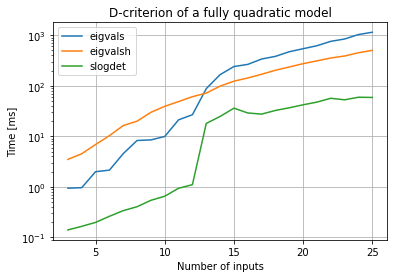

In [73]:
D = np.arange(3, 26)
T1 = np.zeros(len(D))
T2 = np.zeros(len(D))
T3 = np.zeros(len(D))

for i, d in enumerate(D):
    problem_context = ProblemContext(opti.Problem(
        inputs=[opti.Continuous(f"x{i+1}", [0, 1]) for i in range(d)],
        outputs=[opti.Continuous("y")],
    ))

    formula =  problem_context.get_formula_from_string(model_type="fully-quadratic")

    n = d**2 + 1

    X = problem_context.problem.sample_inputs(2 * n)
    A = formula.get_model_matrix(X).to_numpy()
    F = A.T @ A

    T1[i] = timeit("logD_eigvals(F)", number=20, globals=globals())
    T2[i] = timeit("logD_eigvalsh(F)", number=20, globals=globals())
    T3[i] = timeit("logD_slogdet(F)", number=20, globals=globals())

fig, ax = plt.subplots()
ax.plot(D, T1 * 1000, label="eigvals")
ax.plot(D, T2 * 1000, label="eigvalsh")
ax.plot(D, T3 * 1000, label="slogdet")
ax.set(xlabel="Number of inputs", ylabel="Time [ms]", title="D-criterion of a fully quadratic model")
ax.grid()
ax.semilogy()
ax.legend()
fig.savefig("time-det.png")